

## Data Analyst Agent Demo

This file contains demo for data analyst agent

### Workflow:


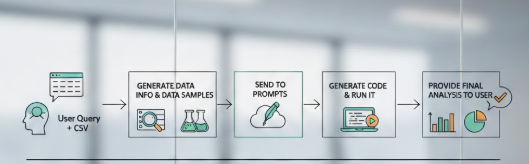

## **Step 1: Clone the Data Analyst Repository**

The DSBC repository contains data analyst agent code

We clone this repository to access the data analyst agent scripts needed for running Data Analysis queries on datasets.

The `--branch` flag is used to clone a **feature branch**

### **Notes**
- The cloned repository includes:
  - Data Analyst agent
  - Evaluation pipelines
  - Metric calculators
- Ensure the correct feature branch is used.



In [1]:
!git clone --branch feature/run_separate_evals https://github.com/traversaal-ai/DSBC-Data-Science-Task-Evaluation.git


Cloning into 'DSBC-Data-Science-Task-Evaluation'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 81 (delta 26), reused 73 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 5.37 MiB | 15.32 MiB/s, done.
Resolving deltas: 100% (26/26), done.





**Open path of DSBC-Data-Science-Task-Evaluation and Install required Python packages from the repository's requirements.txt**
 This ensures all dependencies (LLM clients, evaluation libraries, etc.) are available

- after installing requirements it might ask you restart runtime, make sure you run this cell again

In [1]:
%cd DSBC-Data-Science-Task-Evaluation
#install dependencies
!pip install -r requirements.txt


/home/jupyter/DSBC-Data-Science-Task-Evaluation


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## STEP 2: AI Provider Setup

This section guides you through connecting to the Gemini AI service.

**Prerequisites:**
- Ensure your API keys are stored in Google Colab Secrets
- The key icon in the left sidebar should have "Notebook access" toggled ON

**Model Selection:**
You can select any available Gemini model for your data analysis tasks. The setup uses `gemini-2.5-flash` by default, but you can modify it to use other models

In [ ]:


from google.colab import userdata

# Get Gemini API key from Colab secrets
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

selected_provider = 'gemini'
selected_model = 'gemini-2.5-flash'


# Create .env file
with open('.env', 'w') as f:
    f.write(f'GEMINI_API_KEY={GEMINI_API_KEY}\n')
    f.write(f'LLM_MODEL_NAME={selected_model}\n')
    f.write('LLM_TEMPERATURE=0.3\n')
    f.write('LLM_MAX_TOKENS=8192\n')

print(f" Setup complete!")
print(f"Provider: {selected_provider}")
print(f"Model: {selected_model}")
print(f"\nTo use: selected_provider = '{selected_provider}'")
print(f"        selected_model = '{selected_model}'")

 Setup complete!
Provider: gemini
Model: gemini-2.5-flash

To use: selected_provider = 'gemini'
        selected_model = 'gemini-2.5-flash'


# You can also use vertex ai for google gemini

### Use this code to update repo code of llm_client to add vertex_ai credentials 

In [ ]:
# Cell 1: Update the llm_clients.py file to add VERTEX_AI_AUTO provider

file_path = 'generate_answers/llm_clients.py'

# Read the current file
with open(file_path, 'r') as f:
    content = f.read()

print(" Updating llm_clients.py...")

# 1. Add VERTEX_AI_AUTO to enum (if not already there)
if 'VERTEX_AI_AUTO' not in content:
    content = content.replace(
        'ANTHROPIC_VERTEX = "anthropic_vertex"',
        'ANTHROPIC_VERTEX = "anthropic_vertex"\n    VERTEX_AI_AUTO = "vertex_ai_auto"'
    )
    print("Added VERTEX_AI_AUTO to enum")
else:
    print("VERTEX_AI_AUTO already in enum")

# 2. Add VertexAIAutoClient class (if not already there)
if 'class VertexAIAutoClient' not in content:
    vertex_auto_client = '''

class VertexAIAutoClient(BaseLLMClient):
    """Vertex AI client that auto-detects credentials from Workbench environment"""
    def __init__(self, project_id: str, location: str = "us-central1"):
        import vertexai
        from vertexai.generative_models import GenerativeModel
        
        # Initialize without explicit credentials - will use Application Default Credentials
        vertexai.init(project=project_id, location=location)
        
        self.GenerativeModel = GenerativeModel
    
    def generate(self, prompt: str, config: LLMConfig) -> str:
        model = self.GenerativeModel(config.model_name)
        response = model.generate_content(
            contents=prompt,
            generation_config={
                "temperature": config.temperature,
                "max_output_tokens": config.max_tokens,
            }
        )
        return response.text

'''
    content = content.replace(
        'class AnthropicVertexClient(BaseLLMClient):',
        vertex_auto_client + '\nclass AnthropicVertexClient(BaseLLMClient):'
    )
    print(" Added VertexAIAutoClient class")
else:
    print("  VertexAIAutoClient class already exists")

# 3. Add to create_client function (if not already there)
create_client_check = content[content.find('def create_client'):content.find('class LLMPipeline')]
if 'LLMProvider.VERTEX_AI_AUTO' not in create_client_check:
    vertex_auto_case = '''    elif provider == LLMProvider.VERTEX_AI_AUTO:
        project_id = extra_params.get('project_id')
        if not project_id:
            raise ValueError("Vertex AI Auto requires 'project_id' in extra_params")
        location = extra_params.get('location', 'us-central1')
        return VertexAIAutoClient(project_id, location)
    '''
    content = content.replace(
        '    else:\n        raise ValueError(f"Unsupported provider: {provider}")',
        vertex_auto_case + 'else:\n        raise ValueError(f"Unsupported provider: {provider}")'
    )
    print(" Added VERTEX_AI_AUTO to create_client()")
else:
    print("  VERTEX_AI_AUTO already in create_client()")

# 4. Add to load_config_from_env function (if not already there)
load_config_check = content[content.find('def load_config_from_env'):]
if 'LLMProvider.VERTEX_AI_AUTO' not in load_config_check:
    vertex_auto_config = '''
    elif provider_enum == LLMProvider.VERTEX_AI_AUTO:
        api_key = ''  # Vertex AI Auto uses Application Default Credentials
        model_name = os.getenv('LLM_MODEL_NAME', 'gemini-1.5-pro')
        
        project_id = os.getenv('GOOGLE_CLOUD_PROJECT')
        if not project_id:
            raise ValueError(
                " VERTEX AI AUTO CONFIGURATION ERROR\\n"
                "Missing GOOGLE_CLOUD_PROJECT environment variable.\\n"
                "This should be automatically set in Vertex AI Workbench.\\n"
                "If not, set it manually: export GOOGLE_CLOUD_PROJECT=your-project-id"
            )
        
        extra_params = {
            'project_id': project_id,
            'location': os.getenv('GOOGLE_CLOUD_LOCATION', 'us-central1')
        }
'''
    # Insert before the final return statement
    content = content.replace(
        '\n    return LLMConfig(\n        provider=provider_enum,',
        vertex_auto_config + '\n    return LLMConfig(\n        provider=provider_enum,'
    )
    print(" Added VERTEX_AI_AUTO to load_config_from_env()")
else:
    print("  VERTEX_AI_AUTO already in load_config_from_env()")

# Write back to file
with open(file_path, 'w') as f:
    f.write(content)

print("\n Successfully updated llm_clients.py!")
print("\n Summary:")
print("  ✓ Added VERTEX_AI_AUTO provider enum")
print("  ✓ Added VertexAIAutoClient class")
print("  ✓ Integrated into create_client() function")
print("  ✓ Integrated into load_config_from_env() function")
print("\n Features:")
print("  • Auto-detects Project ID from GOOGLE_CLOUD_PROJECT")
print("  • Uses Application Default Credentials")


📝 Updating llm_clients.py...
VERTEX_AI_AUTO already in enum
  VertexAIAutoClient class already exists
  VERTEX_AI_AUTO already in create_client()
  VERTEX_AI_AUTO already in load_config_from_env()

 Successfully updated llm_clients.py!

 Summary:
  ✓ Added VERTEX_AI_AUTO provider enum
  ✓ Added VertexAIAutoClient class
  ✓ Integrated into create_client() function
  ✓ Integrated into load_config_from_env() function

 Features:
  • Auto-detects Project ID from GOOGLE_CLOUD_PROJECT
  • Uses Application Default Credentials


In [ ]:

import os

selected_provider = "vertex_ai_auto"
selected_model = "gemini-2.5-pro"

GOOGLE_CLOUD_PROJECT='your-project-id'
GOOGLE_CLOUD_LOCATION= 'us-central1'


# Create or update .env file
env_content = f"""# Vertex AI Auto Configuration
GOOGLE_CLOUD_PROJECT={GOOGLE_CLOUD_PROJECT}
GOOGLE_CLOUD_LOCATION={GOOGLE_CLOUD_LOCATION}
GOOGLE_GENAI_USE_VERTEXAI=True

# LLM Configuration
LLM_MODEL_NAME={selected_model}
LLM_TEMPERATURE=0.3
LLM_MAX_TOKENS=8192
"""

# Write to .env file
with open('.env', 'w') as f:
    f.write(env_content)

print(" Created .env file with the following content:")
print("="*60)
print(env_content)
print("="*60)

# Also set them in current session
os.environ['GOOGLE_CLOUD_PROJECT'] = GOOGLE_CLOUD_PROJECT
os.environ['GOOGLE_CLOUD_LOCATION'] = GOOGLE_CLOUD_LOCATION
os.environ['GOOGLE_GENAI_USE_VERTEXAI'] = 'True'
os.environ['LLM_MODEL_NAME'] = selected_model
os.environ['LLM_TEMPERATURE'] = '0.3'
os.environ['LLM_MAX_TOKENS'] = '8192'

print("\n Environment variables also set in current session!")
print("\nCurrent Environment:")
print(f"  GOOGLE_CLOUD_PROJECT: {os.getenv('GOOGLE_CLOUD_PROJECT')}")
print(f"  GOOGLE_CLOUD_LOCATION: {os.getenv('GOOGLE_CLOUD_LOCATION')}")
print(f"  LLM_MODEL_NAME: {os.getenv('LLM_MODEL_NAME')}")
print(f"  LLM_TEMPERATURE: {os.getenv('LLM_TEMPERATURE')}")
print(f"  LLM_MAX_TOKENS: {os.getenv('LLM_MAX_TOKENS')}")

 Created .env file with the following content:
# Vertex AI Auto Configuration
GOOGLE_CLOUD_PROJECT=traversaal-research
GOOGLE_CLOUD_LOCATION=us-central1
GOOGLE_GENAI_USE_VERTEXAI=True

# LLM Configuration
LLM_MODEL_NAME=gemini-2.5-pro
LLM_TEMPERATURE=0.3
LLM_MAX_TOKENS=8192


 Environment variables also set in current session!

Current Environment:
  GOOGLE_CLOUD_PROJECT: traversaal-research
  GOOGLE_CLOUD_LOCATION: us-central1
  LLM_MODEL_NAME: gemini-2.5-pro
  LLM_TEMPERATURE: 0.3
  LLM_MAX_TOKENS: 8192


Or Upload Your .env


In [ ]:

from google.colab import files

uploaded = files.upload()  # select your .env from your local machine


Confirm and view your provider and model

In [9]:
# print(selected_provider)
# print(selected_model)

Check if your model and env is properly set

In [51]:
#  Test the new vertex_ai_auto provider

def test_setup():
    """Test if Vertex AI Auto is working"""
    from generate_answers.llm_clients import load_config_from_env, LLMPipeline
    from dotenv import load_dotenv
    import os
    
    load_dotenv()
    

    
    print(f"Loading configuration for provider: {selected_provider}")
    print(f"Project ID: {os.getenv('GOOGLE_CLOUD_PROJECT')}")
    print(f"Location: {os.getenv('GOOGLE_CLOUD_LOCATION')}")
    print(f"Model: {os.getenv('LLM_MODEL_NAME', 'gemini-2.5-pro')}")
    print()
    
    try:
        config = load_config_from_env(selected_provider)
        print(f"Config loaded successfully!")
        print(f"   Provider: {config.provider}")
        print(f"   Model: {config.model_name}")
        print()
        
        pipeline = LLMPipeline(config)
        print(" Sending test prompt...")
        
        response = pipeline.answer_question(
            "Say 'Hello, I'm working!' in a friendly way. What model are you?"
        )
        
        print("\n" + "="*60)
        print(" Response:")
        print("="*60)
        print(response)
        print("="*60)
        print("\n Vertex AI Auto is working!")
        
    except Exception as e:
        print(f"\n Error: {e}")
        import traceback
        traceback.print_exc()

print("\n Running test_setup()...")
print("="*60)
test_setup()



 Running test_setup()...
Loading configuration for provider: vertex_ai_auto
Project ID: traversaal-research
Location: us-central1
Model: gemini-2.5-pro

Config loaded successfully!
   Provider: LLMProvider.VERTEX_AI_AUTO
   Model: gemini-2.5-pro

 Sending test prompt...

 Response:
Hello! I'm working away!

I am a large language model, trained by Google.

 Vertex AI Auto is working!


In [53]:
with open('.env', 'r') as f:
    print(f.read())

# Vertex AI Auto Configuration
GOOGLE_CLOUD_PROJECT=traversaal-research
GOOGLE_CLOUD_LOCATION=us-central1
GOOGLE_GENAI_USE_VERTEXAI=True

# LLM Configuration
LLM_MODEL_NAME=gemini-2.5-pro
LLM_TEMPERATURE=0.3
LLM_MAX_TOKENS=8192



## Prompt and Dataset Context

The following prompts and dataset metadata are provided to the data analyst agent to enable code generation and analysis.

### Viewing Agentic System Prompts

In [19]:
# Read and display prompts from the repository file
# Load prompt from cloned repo
file_path = 'generate_answers/datascience/prompts.py'

print("=" * 80)
print("PROMPTS BEING USED")
print("=" * 80)
print(f"\nFile: {file_path}")
print("\n" + "=" * 80)

# Read the file
with open(file_path, 'r') as f:
    content = f.read()

# Print the entire file content
print(content)

print("\n" + "=" * 80)



PROMPTS BEING USED

File: generate_answers/datascience/prompts.py

data_analyst_prompt="""You are a data analyst. Generate Python code to analyze a CSV file and answer
the following query: {user_query}

Here is information about CSV file:
data samples : {csv_data_string}
data info : {csv_data_info}

# # # # # # # # # # # # # # # # # # # # #
Requirements:
- Use pandas to load and analyze the data: pd.read_csv('data.csv')
- Include necessary imports
- Use print() statements to show results
- For visualizations, use matplotlib/seaborn
- Handle data type conversions if needed
- Return ONLY executable Python code, no markdown formatting
- The dataframe is already loaded in a variable called 'data'. Do not re-read it
- Have the answer ready in a variable called 'answer'.
Just declare and add your values there.
- Do not have subplots, only main plots
Generate clean, executable Python code
For the Explination, it should describe why a step was taken and not whats done.

Return ONLY a valid JSO

## STEP 3: Load Dataset and Extract Metadata

Load the dataset and extract comprehensive information to provide context for the LLM's analysis.

**Dataset Context Variables:**

The LLM receives two key pieces of information about the dataset:

1. **`csv_data_string`** (Data Samples)
   - Contains the first 5 rows of the dataset
   - Provides a quick preview of actual data values and structure

2. **`csv_data_info`** (Dataset Metadata)
   - Comprehensive statistical and structural profile of the dataset
   - Includes the following information:

   | Field | Description |
   |-------|-------------|
   | `number_of_rows` | Total count of records/observations in the dataset |
   | `number_of_columns` | Total count of features/variables in the dataset |
   | `columns` | Dictionary mapping each column name to its data type (int64, float64, object, etc.) |
   | `sample_rows` | First 10 rows of data as list of dictionaries for quick preview |
   | `frequency` | Inferred time frequency for datetime columns (e.g., 'H' for hourly, 'D' for daily) or 'Not Applicable' |
   | `null_counts` | Dictionary showing columns with missing values and their respective counts |
   | `numeric_stats` | Statistical summary (min, max, mean, median) for each numerical column |
   | `categorical_info` | Unique value counts and top/sample values for text/categorical columns |
   | `date_ranges` | Min and max dates for each datetime column showing data coverage period |

**Purpose:** This metadata enables the LLM to understand the dataset's structure, data types, and statistical properties before generating analysis code.

In [ ]:
#TO-DO
#Add option to upload custom data_dictionary

In [35]:
from generate_answers.datascience.data_info import get_dataframe_info
import pandas as pd
#load your own file or access file already downloaded in path
data_path = os.path.abspath("../sample_grocery_store_sales_april_2025.csv")

df=pd.read_csv(data_path)

df.head()

,Transaction ID,Date,Product,Unit Price,Quantity,Total Price
0,1000,2025-04-01,Apples,0.75,5,3.75
1,1001,2025-04-01,Rice,2.00,1,2.00
2,1002,2025-04-01,Chicken,5.00,3,15.00
3,1003,2025-04-01,Pasta,1.20,4,4.80
4,1004,2025-04-01,Bread,1.00,5,5.00


In [36]:
# view what is in csv_data_info


csv_data_info = get_dataframe_info(df)
csv_data_info

{'number_of_rows': 1085,
 'number_of_columns': 6,
 'columns': {'Transaction ID': 'int64',
  'Date': 'object',
  'Product': 'object',
  'Unit Price': 'float64',
  'Quantity': 'int64',
  'Total Price': 'float64'},
 'sample_rows': [{'Transaction ID': 1000,
   'Date': '2025-04-01',
   'Product': 'Apples',
   'Unit Price': 0.75,
   'Quantity': 5,
   'Total Price': 3.75},
  {'Transaction ID': 1001,
   'Date': '2025-04-01',
   'Product': 'Rice',
   'Unit Price': 2.0,
   'Quantity': 1,
   'Total Price': 2.0},
  {'Transaction ID': 1002,
   'Date': '2025-04-01',
   'Product': 'Chicken',
   'Unit Price': 5.0,
   'Quantity': 3,
   'Total Price': 15.0},
  {'Transaction ID': 1003,
   'Date': '2025-04-01',
   'Product': 'Pasta',
   'Unit Price': 1.2,
   'Quantity': 4,
   'Total Price': 4.8},
  {'Transaction ID': 1004,
   'Date': '2025-04-01',
   'Product': 'Bread',
   'Unit Price': 1.0,
   'Quantity': 5,
   'Total Price': 5.0},
  {'Transaction ID': 1005,
   'Date': '2025-04-01',
   'Product': 'Banana

In [26]:
#create string for 5 sample rows for LLM
data_sample = df.head(5)
csv_data_string = data_sample.to_string(index=False)
csv_data_string

' Transaction ID       Date Product  Unit Price  Quantity  Total Price\n           1000 2025-04-01  Apples        0.75         5         3.75\n           1001 2025-04-01    Rice        2.00         1         2.00\n           1002 2025-04-01 Chicken        5.00         3        15.00\n           1003 2025-04-01   Pasta        1.20         4         4.80\n           1004 2025-04-01   Bread        1.00         5         5.00'

## STEP 4: Execute Data Analyst Agent

Test the data analyst agent by running a single query against your dataset.

**What This Does:**
- Processes your natural language query
- Generates Python code for analysis
- Executes the code on your dataset
- Returns results with explanations and reasoning

**Usage:**
Provide a query and dataset file path to receive data analysis.

In [34]:
# Test the setup with your query
# Parameters:
# --query: Your question about the data
# --filepath: Path to your CSV file
# --provider: AI provider (gemini)
# --model: Gemini model to use
import os

# Build the command as a Python string first
!python main.py \
--mode single \
--query "Which category generated the highest revenue?" \
--filepath {data_path} \
--provider {selected_provider} \
--model {selected_model}

DSBC SINGLE QUERY EVALUATION
Query: Which category generated the highest revenue?
Dataset: /home/jupyter/sample_grocery_store_sales_april_2025.csv
Provider: vertex_ai_auto
Model: gemini-2.5-pro
Temperature: 0.3
----------------------------------------------------------------------
Provider: vertex_ai_auto
Model: gemini-2.5-pro
Temperature: 0.3
/opt/conda/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)
Answering your query ...
Query answered!

=== RESULTS ===
{'status': 'sucess', 'code': '\nCODE: import pandas as pd\nimport matplotlib.pyplot as plt\nimport io\n\n# The dataframe \'data\' is already loaded. \n# For demo

In [37]:
# Capture the JSON results in a variable and display them separately

import subprocess
import json
import ast

# Run the command and capture output
result = subprocess.run([
    'python', 'main.py',
    '--mode', 'single',
    '--query', 'Which category generated the highest revenue?',
    '--filepath', data_path,
    '--provider', selected_provider,
    '--model', selected_model
], capture_output=True, text=True)

output = result.stdout + result.stderr

# Find and extract the results dict
lines = output.split('\n')
results = None

for i, line in enumerate(lines):
    if '=== RESULTS ===' in line:
        dict_str = lines[i + 1]
        results = ast.literal_eval(dict_str)
        break

# Print the results
if results:
    print(json.dumps(results, indent=2))
    print(f"\n Results captured in 'results' variable")
    print(f"Keys: {list(results.keys())}")
else:
    print(" Could not extract results")
    print(output)

{
  "status": "sucess",
  "code": "\nCODE: import pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# The 'data' DataFrame is assumed to be pre-loaded.\n# To find the category with the highest revenue, we group the data by 'Product' and sum the 'Total Price'.\nrevenue_by_category = data.groupby('Product')['Total Price'].sum()\n\n# Find the category with the maximum revenue using idxmax() to get the name and max() for the value.\nhighest_revenue_category_name = revenue_by_category.idxmax()\nhighest_revenue_value = revenue_by_category.max()\n\n# Store the final answer in the 'answer' variable as requested.\nanswer = f\"The category that generated the highest revenue is '{highest_revenue_category_name}'.\"\n\n# Print the detailed results.\nprint(\"--- Total Revenue by Product Category ---\")\n# Sorting the values for a clear, ranked view.\nprint(revenue_by_category.sort_values(ascending=False).round(2))\nprint(\"\\n\" + \"=\"*40)\nprint(answer)\nprint(f\"Total Revenu

# STEP 5:
Output from Data Analyst Agent:

The output contains four key components:

**status**: Indicates whether the data analyst agent executed successfully

**code**: The Python code generated by the LLM

**output**: The results produced by executing the generated code

**reasoning**: The LLM's explanation for why it generated this specific code

**analysis**: The LLM's interpretation and insights derived from the code output

###The code generated by agent

In [38]:
results["code"]

'\nCODE: import pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# The \'data\' DataFrame is assumed to be pre-loaded.\n# To find the category with the highest revenue, we group the data by \'Product\' and sum the \'Total Price\'.\nrevenue_by_category = data.groupby(\'Product\')[\'Total Price\'].sum()\n\n# Find the category with the maximum revenue using idxmax() to get the name and max() for the value.\nhighest_revenue_category_name = revenue_by_category.idxmax()\nhighest_revenue_value = revenue_by_category.max()\n\n# Store the final answer in the \'answer\' variable as requested.\nanswer = f"The category that generated the highest revenue is \'{highest_revenue_category_name}\'."\n\n# Print the detailed results.\nprint("--- Total Revenue by Product Category ---")\n# Sorting the values for a clear, ranked view.\nprint(revenue_by_category.sort_values(ascending=False).round(2))\nprint("\\n" + "="*40)\nprint(answer)\nprint(f"Total Revenue: ${highest_revenue_value:,.

### Executed output of code generated

In [39]:
results["output"]

"Step 1 Output:\n--- Total Revenue by Product Category ---\nProduct\nChicken         1810.0\nCheese          1014.0\nOrange Juice     890.4\nEggs             830.0\nRice             762.0\nMilk             481.5\nPasta            364.8\nBread            340.0\nApples           249.0\nBananas           91.8\nName: Total Price, dtype: float64\n\n========================================\nThe category that generated the highest revenue is 'Chicken'.\nTotal Revenue: $1,810.00\n========================================\nSTDERR: <string>:28: FutureWarning: \n\nPassing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect."

### Reason why was this code generated

In [40]:
results["reasoning"]

"### STEP 1 ### : To determine the category with the highest revenue, the dataset is grouped by the 'Product' column. The 'Total Price' for each transaction within a product group is then summed up to calculate the total revenue for that specific product. The `idxmax()` function is used on the resulting series to efficiently find the product name (the index) corresponding to the maximum revenue value. Finally, a bar chart is created to visually compare the total revenues across all product categories, providing a clear and immediate confirmation of the result."

### Final Analysis Generated by Agent

In [41]:
results["analysis"]

"Of course! Here is a clear explanation of the findings from your data.\n\nBased on my analysis of your sales data, I found that **Chicken** is the category that generated the highest revenue.\n\nHere's a quick breakdown of what this means:\n\n*   **Top Performer:** Chicken brought in a total of **$1,810.00**, making it your most profitable product by a significant margin.\n*   **The Runner-Up:** The next highest category was 'Cheese', which generated $1,014.00 in revenue. The large gap highlights just how important 'Chicken' is to your overall sales.\n*   **Key Insight:** The high revenue from 'Chicken' is driven by a combination of its high unit price and frequent sales. In contrast, products like 'Bananas' and 'Apples', while sold often, have lower unit prices and therefore contribute the least to your total revenue.\n\nIn practical terms, 'Chicken' is the star player in your product lineup when it comes to generating income."